# Challenge: Edit MNIST challenge images to be correctly predicted

Goal: Edit the images placed in `data/MNIST/challenge` so that the provided model predicts the correct label while keeping more than 60% of the original pixels unchanged.

Description: You are given a pre-trained `SmallCNN` model and a small set of challenge images. Your task is to minimally modify these images so the model classifies them correctly. This exercise encourages you to: 
- Explore the sample dataset in `data/MNIST/sample` to understand variation and typical inputs.
- Use explainable AI (XAI) techniques (saliency maps, Grad-CAM, Integrated Gradients, occlusion, etc.) to discover what parts of the image the model relies on.
- Propose minimal edits (pixel changes, small masks, subtle color shifts) that change model prediction while preserving at least 60% of the original pixels.

Deliverables: For each edited image, save the modified image to `data/MNIST/challenge/edited/` alongside a short report (less than 2 pages) describing the XAI insights you used and the percentage of pixels preserved. For ease of use, you have the images already in that folder and you can directly work on them. You are allowed to use any external program you want to modify the image (i.e., paint, photoshop, figma, ...).

The practice can be done by more than 1 person. Final grade would depend on the number of images correctly edited (n_images_correct) with their corresponding report and number of persons working together (n_persons) following the next formula:
$$grade = 2,5 \times n\_images\_correct - 2,5 * (n\_persons - 1)$$


In [1]:
# Imports and device
import torch
import torch.nn as nn
from torchvision import transforms
import matplotlib.pyplot as plt
from pathlib import Path
from PIL import Image

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if torch.backends.mps.is_available():
    device = torch.device('mps')
print('Device:', device)

Device: mps


In [2]:
# SmallCNN definition (must match the trained model architecture)
class SmallCNN(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 12, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2,2)
        self.dropout = nn.Dropout(0.25)
        self.fc1 = nn.Linear(12*7*7, 12)
        self.fc2 = nn.Linear(12, num_classes)

    def forward(self, x):
        x = self.pool(torch.nn.functional.relu(self.conv1(x)))  # 14x14
        x = self.pool(x)                      # 7x7
        x = x.view(x.size(0), -1)
        x = self.dropout(torch.nn.functional.relu(self.fc1(x)))
        return self.fc2(x)

# convenience transform
to_tensor = transforms.ToTensor()
to_pil = transforms.ToPILImage()

In [3]:
models_dir = Path('../models')
model_name = models_dir / 'small_cnn.pth'
model = torch.load(model_name, weights_only=False, map_location=device)
model.to(device) 
model.eval()

SmallCNN(
  (conv1): Conv2d(3, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.25, inplace=False)
  (fc1): Linear(in_features=588, out_features=12, bias=True)
  (fc2): Linear(in_features=12, out_features=10, bias=True)
)

3_label7.png: Pred: 3, Label: 7
1_label3.png: Pred: 1, Label: 3
4_label2.png: Pred: 6, Label: 2
2_label3.png: Pred: 1, Label: 3
0_label5.png: Pred: 1, Label: 5


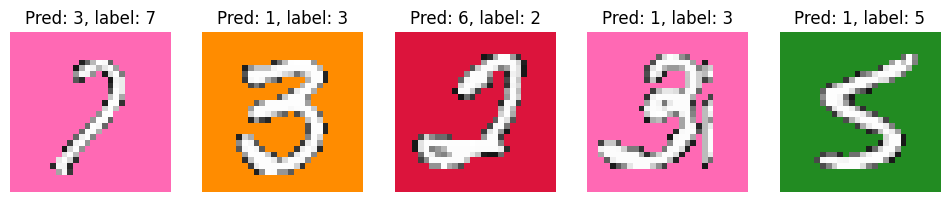

In [4]:
# Load the images in data/MNIST/challenge/ and plot them. Label of the image is the last character of the filename.
challenge_dir = Path('../data/MNIST/challenge')
image_files = list(challenge_dir.glob('*.png'))
fig, axes = plt.subplots(1, len(image_files), figsize=(12,4))
for ax, img_file in zip(axes, image_files):
    img = to_tensor(Image.open(img_file)).unsqueeze(0).to(device)
    with torch.no_grad():
        output = model(img)
        pred = output.argmax(dim=1).item()
    ax.imshow(to_pil(img.squeeze().cpu()))
    ax.set_title(f'Pred: {pred}, label: {img_file.stem[-1]}')
    ax.axis('off')
    print(f'{img_file.name}: Pred: {pred}, Label: {img_file.stem[-1]}')
plt.show()

---
### Any code you want to add, put it below this markdown cell

In [5]:
import sys
import os
sys.path.append(os.path.abspath('..'))

from utils.xai import saliency_map, integrated_gradients

## Imagen 2

In [6]:
images_dir = Path('../data/MNIST/sample')
challenge_dir = Path('../data/MNIST/challenge')
sample_images = [
    (int(img_file.stem[-1]), to_tensor(Image.open(img_file)).unsqueeze(0).to(device)) for img_file in sorted(images_dir.glob('*.png'))
]

challenge_images = [
    (int(img_file.stem[-1]), to_tensor(Image.open(img_file)).unsqueeze(0).to(device)) for img_file in sorted(challenge_dir.glob('*.png'))
]

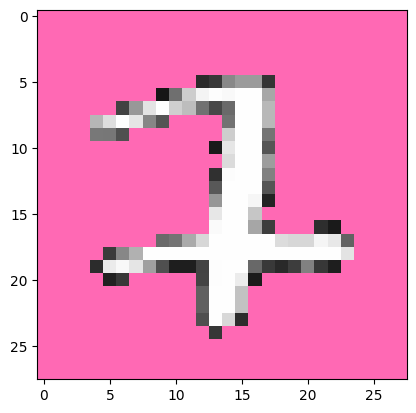

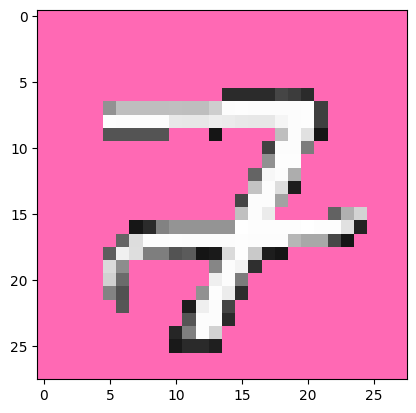

In [7]:
for label, img in sample_images:
    output = model(img)
    pred = output.argmax(dim=1).item()
    if pred == 5:
        plt.imshow(to_pil(img.squeeze().cpu()))
        plt.show()

In [8]:
# print images in order
for label, img_tensor in challenge_images:
    with torch.no_grad():
        output = model(img_tensor)
        pred = output.argmax(dim=1).item()
    print(f'Label: {label}, Pred: {pred}')

Label: 5, Pred: 1
Label: 3, Pred: 1
Label: 3, Pred: 1
Label: 7, Pred: 3
Label: 2, Pred: 6


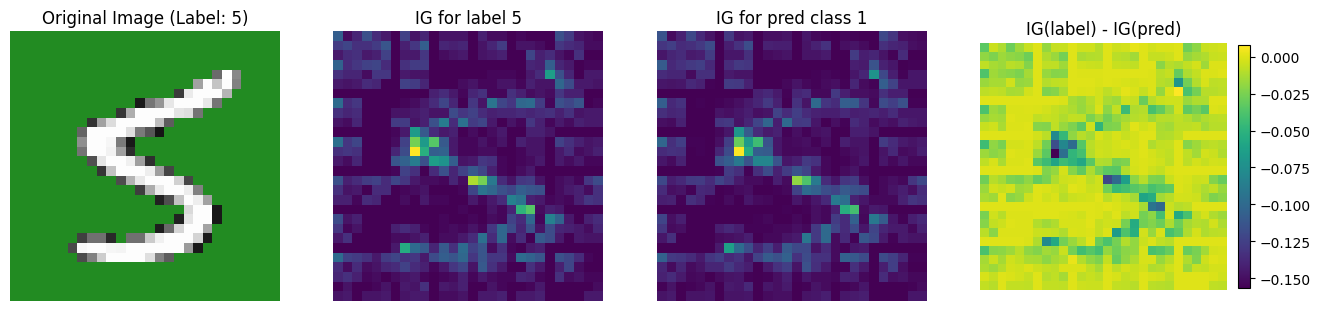

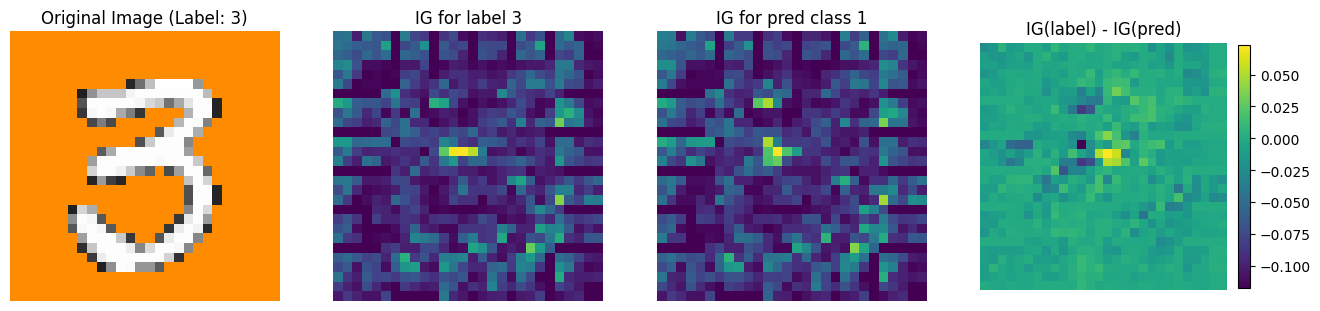

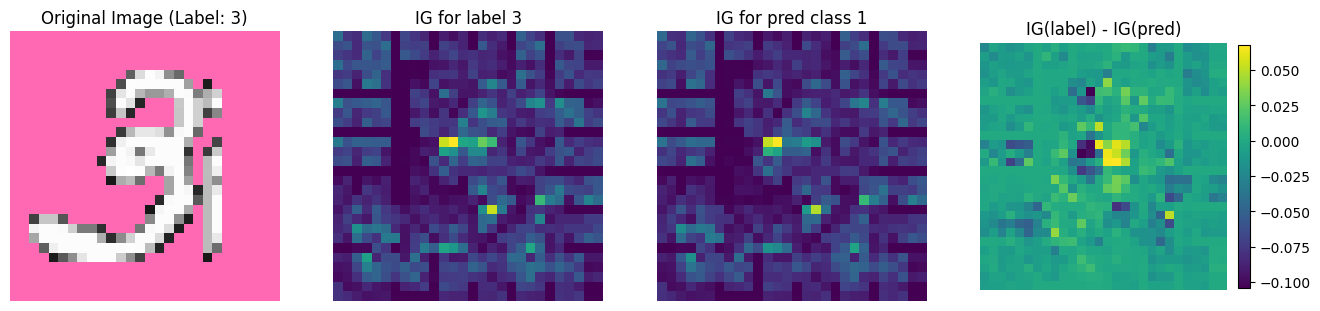

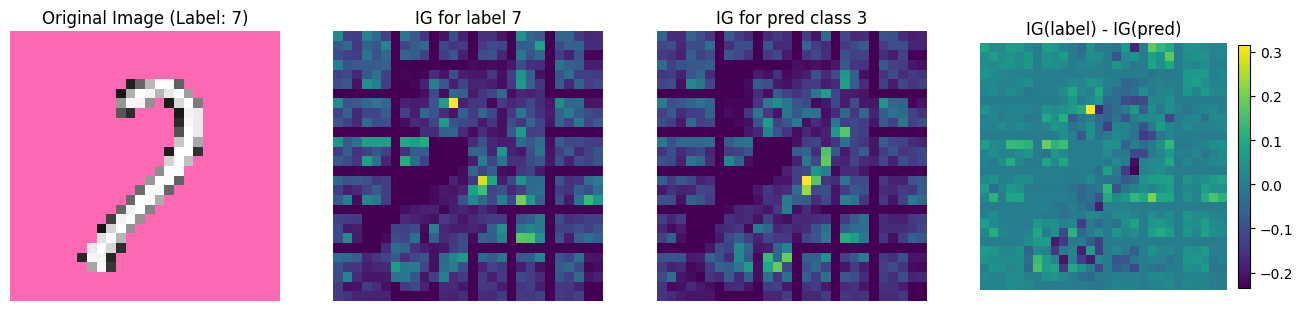

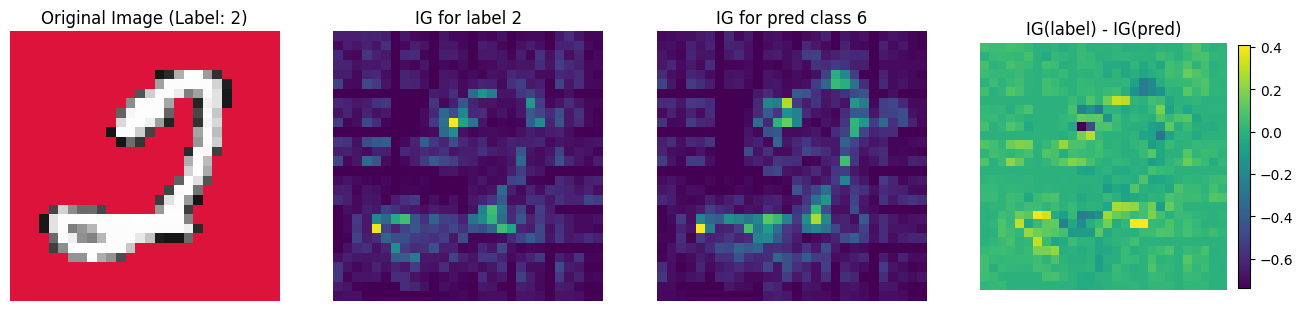

In [9]:
ig_difs = []
ig_preds = []
ig_labels = []
for label, img in challenge_images:
    with torch.no_grad():
        output = model(img)
        pred = output.argmax(dim=1).item()
    # Plot original image and saliency map
    fig, axes = plt.subplots(1, 4, figsize=(16,4))
    axes[0].imshow(to_pil(img.squeeze().cpu()))
    axes[0].set_title(f'Original Image (Label: {label})')
    axes[0].axis('off')
    ig_label = integrated_gradients(model, img, target_class=label)
    ig_label_gray = ig_label.abs().sum(dim=0)
    ig_labels.append(ig_label_gray)
    axes[1].imshow(to_pil(ig_label_gray.cpu()))
    axes[1].set_title(f'IG for label {label}')
    axes[1].axis('off')
    ig_pred = integrated_gradients(model, img, target_class=pred)
    ig_pred_gray = ig_pred.abs().sum(dim=0)
    ig_preds.append(ig_pred_gray)
    axes[2].imshow(to_pil(ig_pred_gray.cpu()))
    axes[2].set_title(f'IG for pred class {pred}')
    axes[2].axis('off')
    ig_dif = ig_label_gray - ig_pred_gray
    ig_difs.append(ig_dif)
    axes[3].imshow(ig_dif.cpu())
    axes[3].set_title(f'IG(label) - IG(pred)')
    axes[3].axis('off')
    # Plot colorbar
    plt.colorbar(axes[3].images[0], ax=axes[3], fraction=0.045, pad=0.04)
    
    plt.show()

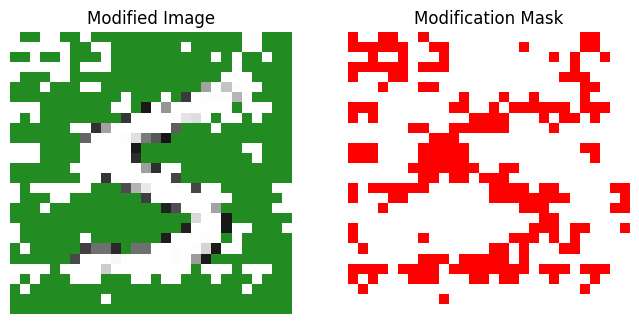

New prediction after modification: 1
Logits: {0: -1.1748286, 1: 1.7352741, 2: -1.7384547, 3: 1.5981292, 4: -1.905802, 5: 1.446992, 6: -1.2318575, 7: 0.5896318, 8: -0.93395853, 9: 0.10081268}


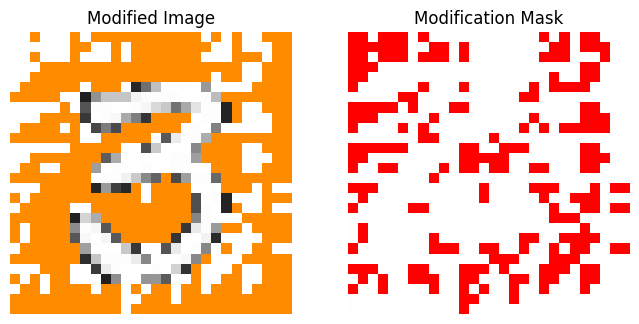

New prediction after modification: 3
Logits: {0: -1.5371406, 1: 1.1627233, 2: -2.007715, 3: 1.2624775, 4: -1.7574775, 5: 1.1798098, 6: -1.0748993, 7: 0.78672004, 8: -1.0333288, 9: 0.35620585}


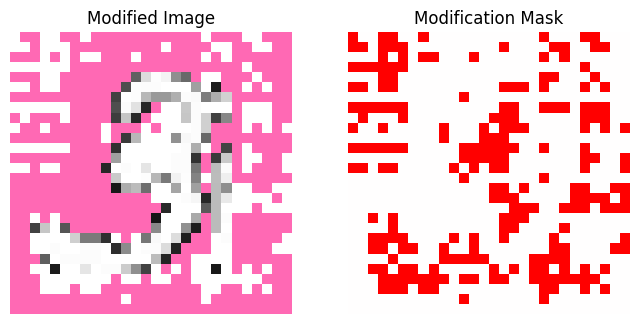

New prediction after modification: 1
Logits: {0: -1.1748286, 1: 1.7352741, 2: -1.7384547, 3: 1.5981292, 4: -1.905802, 5: 1.446992, 6: -1.2318575, 7: 0.5896318, 8: -0.93395853, 9: 0.10081268}


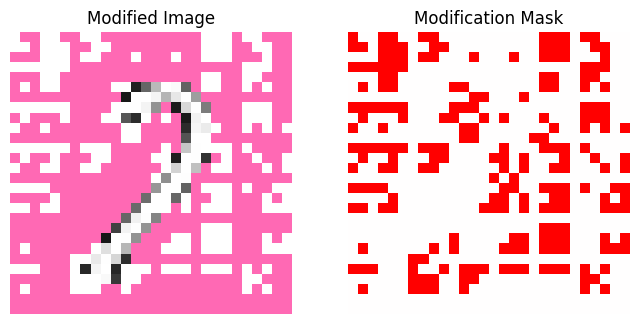

New prediction after modification: 7
Logits: {0: -2.6719258, 1: -0.6305442, 2: -2.8510556, 3: 0.21119416, 4: -1.2929156, 5: 0.34297693, 6: -0.58329576, 7: 1.4040136, 8: -1.344563, 9: 1.1561143}


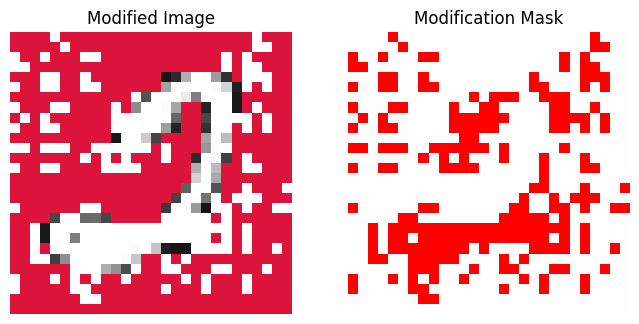

New prediction after modification: 6
Logits: {0: 1.5400602, 1: -18.716959, 2: 5.8005686, 3: -18.25494, 4: 2.188265, 5: -11.557057, 6: 5.9963818, 7: -20.5539, 8: 0.6545266, 9: -19.737993}


In [ ]:
for image_idx in [0, 1, 2, 3, 4]:
    label, img = challenge_images[image_idx]
    # For the digits of ig_label which are (in absolute value) the largest, save the indices
    ig_label = ig_labels[image_idx]
    ig_label_abs = ig_label.abs()
    threshold = torch.quantile(ig_label_abs, 0.72)
    mask = ig_label_abs > threshold
    mask_pos_neg = mask * torch.sign(ig_label)

    # Apply the mask
    # If it is a 1, convert all original pixel to white (1), if -1 convert to black (0), if 0 leave unchanged
    mask_expanded = mask_pos_neg.unsqueeze(0).unsqueeze(0)  # shape (1,1,H,W)
    mask_expanded = mask_expanded.repeat(1, 3, 1, 1)        # shape (1,3,H,W)
    modified_img = img.clone()
    modified_img[mask_expanded == 1] = 1.0
    modified_img = torch.where(mask_expanded == -1, img[0, :, 0, 0].view(1, 3, 1, 1), modified_img)

    # Plot modified image and mask
    fig, axes = plt.subplots(1, 2, figsize=(8,4))
    axes[0].imshow(to_pil(modified_img.squeeze().cpu()))
    axes[0].set_title('Modified Image')
    axes[0].axis('off')
    axes[1].imshow(mask_pos_neg.squeeze().cpu(), cmap='bwr', vmin=-1, vmax=1)
    axes[1].set_title('Modification Mask')
    axes[1].axis('off')
    plt.show()


    with torch.no_grad():
        output = model(modified_img)
        pred = output.argmax(dim=1).item()
    print(f'New prediction after modification: {pred}')
    logits_dict = {i: logit for i, logit in enumerate(output.cpu().numpy()[0])}
    print(f"Logits: {logits_dict}")

---
## Check if you have passed the challenge 

In [ ]:
# Check percentage of editing an image
def calculate_edit_percentage(original_img, edited_img):
    original_pixels = original_img.load()
    edited_pixels = edited_img.load()
    width, height = original_img.size
    total_pixels = width * height
    changed_pixels = 0

    for x in range(width):
        for y in range(height):
            if original_pixels[x, y] != edited_pixels[x, y]:
                changed_pixels += 1

    return (changed_pixels / total_pixels) * 100

In [ ]:
# Create edited directory
edited_dir = challenge_dir / 'edited'

# Load edited images, check that they are predicted correctly and calculate edit percentages
for original_img_file, edited_img_file in zip(challenge_dir.glob('*.png'), edited_dir.glob('*.png')):
    original_img = Image.open(original_img_file)
    edited_img = Image.open(edited_img_file)
    # Convert the edited image to RGB if it's not
    if edited_img.mode != 'RGB':
        edited_img = edited_img.convert('RGB')

    # Check prediction
    img_tensor = to_tensor(edited_img).unsqueeze(0).to(device)
    with torch.no_grad():
        output = model(img_tensor)
        pred = output.argmax(dim=1).item()
    
    print(f'Edited {edited_img_file.name}: Pred: {pred}, Label: {original_img_file.stem[-1]}, correct: {pred == int(original_img_file.stem[-1])}')

    # Calculate edit percentage
    edit_percentage = calculate_edit_percentage(original_img, edited_img)
    print(f'Edit Percentage: {edit_percentage:.2f}%')
